# CS436 Computer Vision Project - Week 1 Deliverable


**Student:** Muhammad Zain Naseer , Kousar Pervaiz



In [22]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob


plt.rcParams['figure.figsize'] = (12, 10)


## 1. Load Image Dataset



In [23]:

IMAGE_DIR = r"images"  


image_paths = sorted(glob.glob(f"{IMAGE_DIR}/*.jpg"))

print(f"{len(image_paths)} images")

26 images


In [24]:

images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    else:
        print(f"Warning: Could not load {path}")

print(f"Loaded {len(images)} images successfully")
if len(images) > 0:
    print(f"Image shape: {images[0].shape}")

Loaded 26 images successfully
Image shape: (8160, 6120, 3)


## 2. Display Image Grid (10 Images)

Displaying a grid of 10 images from the dataset to show the variety of viewpoints.

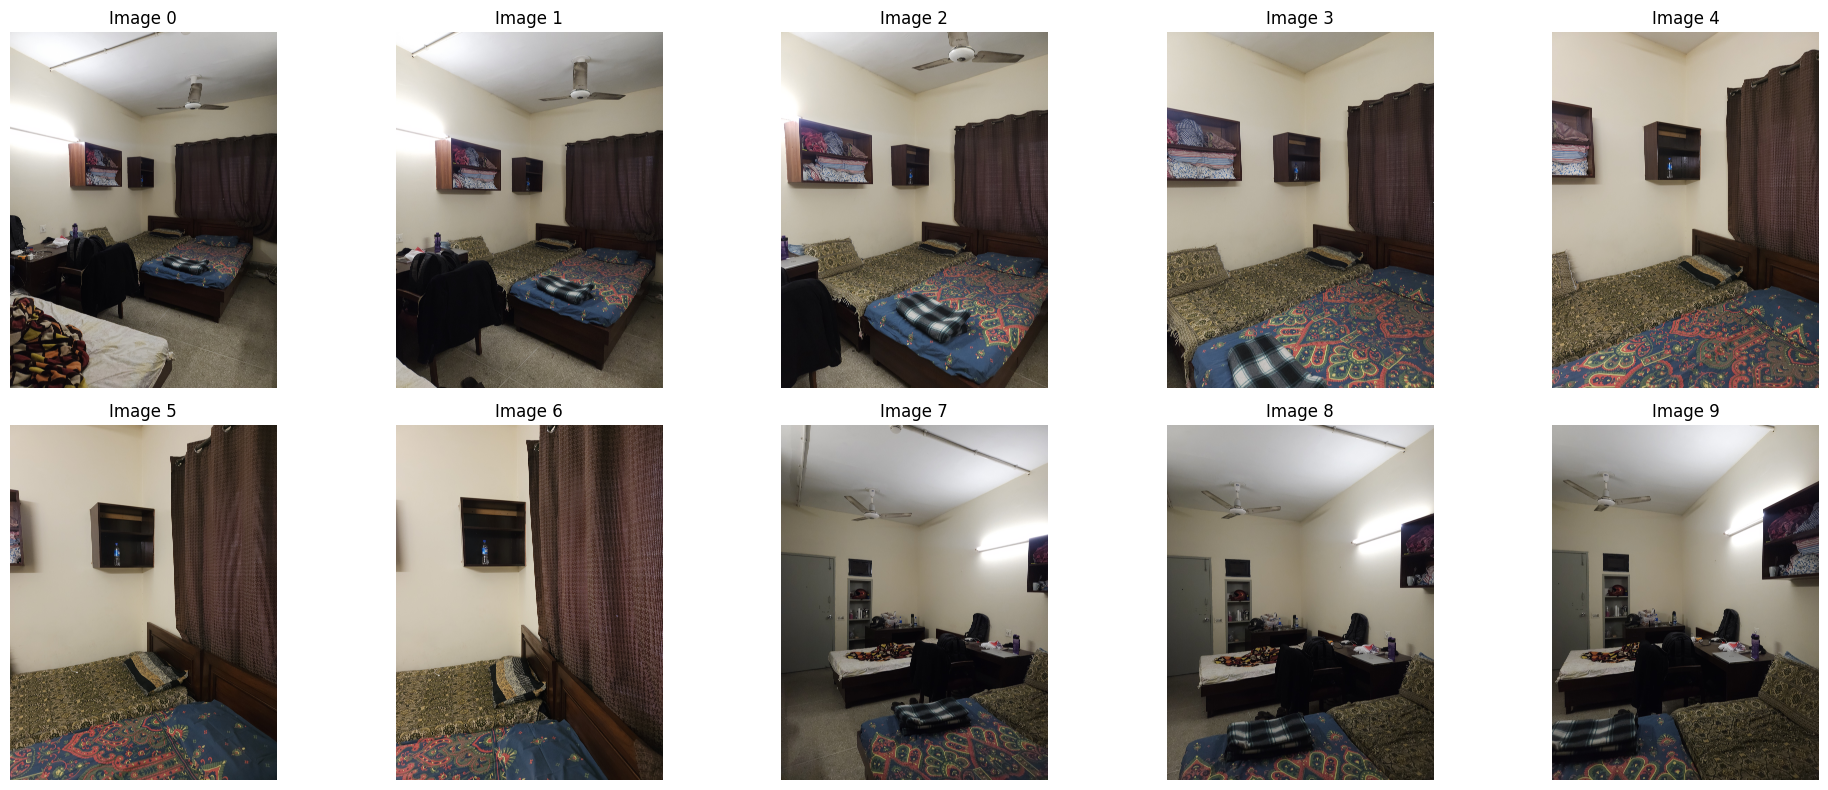

In [25]:
def display_image_grid(images, n_images, cols):

    n_images = min(n_images, len(images))
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for i in range(n_images):
        axes[i].imshow(images[i])
        axes[i].set_title(f'Image {i}', fontsize=12)
        axes[i].axis('off')
    

    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

display_image_grid(images, n_images=10, cols=5)

## 3. Image Preprocessing



In [26]:
def preprocess_image(img, target_width=1920, convert_to_gray=True):

    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    

    h, w = img_bgr.shape[:2]
    if w > target_width:
        scale = target_width / w
        new_w = int(w * scale)
        new_h = int(h * scale)
        img_bgr = cv2.resize(img_bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)
    

    

    if convert_to_gray:
        return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    else:
     
        return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


if len(images) > 0:
    sample_img = images[0]
    print(f"Original image shape: {sample_img.shape}")
    

    preprocessed_images = []
    for img in images:
        preprocessed = preprocess_image(img, convert_to_gray=True)
        preprocessed_images.append(preprocessed)
    
    print(f"Preprocessed {len(preprocessed_images)} images")
    print(f"Preprocessed image shape: {preprocessed_images[0].shape}")
    print(f"Image is now grayscale: {len(preprocessed_images[0].shape) == 2}")
else:
    preprocessed_images = images
    print("No preprocessing applied (using original images)")

Original image shape: (8160, 6120, 3)
Preprocessed 26 images
Preprocessed image shape: (2560, 1920)
Image is now grayscale: True


## 4. Feature Detection and Matching

Using SIFT (Scale-Invariant Feature Transform) to detect and match features between consecutive images.

### 4.1 Feature Detection Setup

In [27]:

sift = cv2.SIFT_create(nfeatures=5000)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

print("Feature detector and matcher initialized")

Feature detector and matcher initialized


### 4.2 Detect Features in All Images

In [28]:

# keypoints_list = []
# descriptors_list = []

# for i, img in enumerate(preprocessed_images):
    
    
#     kp, desc = sift.detectAndCompute(img, None)
    
#     keypoints_list.append(kp)
#     descriptors_list.append(desc)

# print(f"\nTotal images processed: {len(keypoints_list)}")



# Detect features in all images AND keep color versions
keypoints_list = []
descriptors_list = []
images_color = []  # NEW: Keep color versions for point cloud

for i, img in enumerate(preprocessed_images):
    kp, desc = sift.detectAndCompute(img, None)
    keypoints_list.append(kp)
    descriptors_list.append(desc)
    
    # NEW: Also store color version of the preprocessed image
    img_color = preprocess_image(images[i], convert_to_gray=False)
    images_color.append(img_color)

print(f"\nTotal images processed: {len(keypoints_list)}")
print(f"Color images stored: {len(images_color)}")


Total images processed: 26
Color images stored: 26


### 4.3 Visualize Keypoints on Sample Image

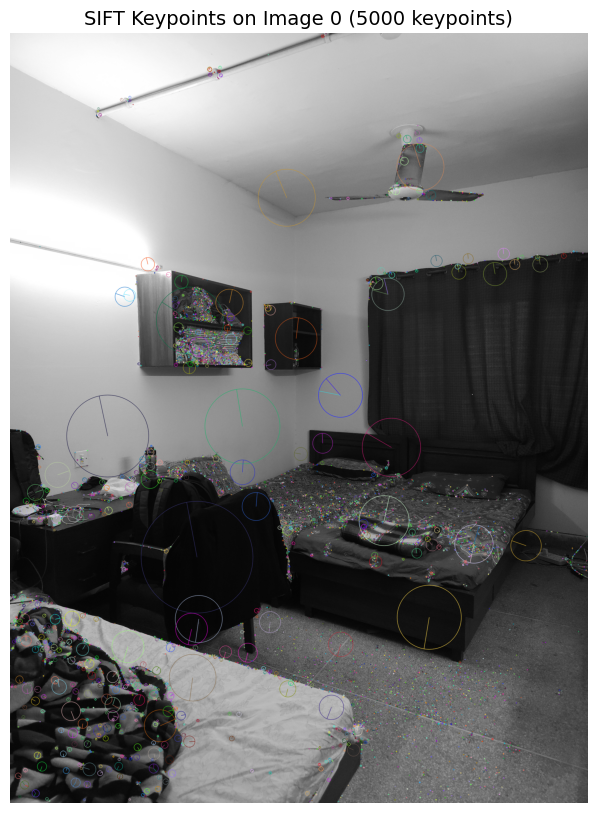

In [29]:

img_with_kp = cv2.drawKeypoints(
    cv2.cvtColor(preprocessed_images[0], cv2.COLOR_RGB2BGR),
    keypoints_list[0],
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.title(f'SIFT Keypoints on Image 0 ({len(keypoints_list[0])} keypoints)', fontsize=14)
plt.axis('off')
plt.show()

## 5. Feature Matching Between Consecutive Images

Matching features between 4-5 consecutive image pairs using Lowe's ratio test.

In [30]:
def match_features(desc1, desc2, ratio_thresh=0.7):

    matches = flann.knnMatch(desc1, desc2, k=2)
    
    
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
    
    return good_matches

def visualize_matches(img1, kp1, img2, kp2, matches, title=""):
    
    
    img1_bgr = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    img2_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
    
    
    img_matches = cv2.drawMatches(
        img1_bgr, kp1, img2_bgr, kp2, matches[:50], None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    
    plt.figure(figsize=(20, 10))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(title, fontsize=14)
    plt.axis('off')
    return img_matches

### 5.1 Match Features Between 4-5 Consecutive Image Pairs

Matching features between 5 consecutive image pairs


--- Matching Image 0 and Image 1 ---
Found 807 good matches


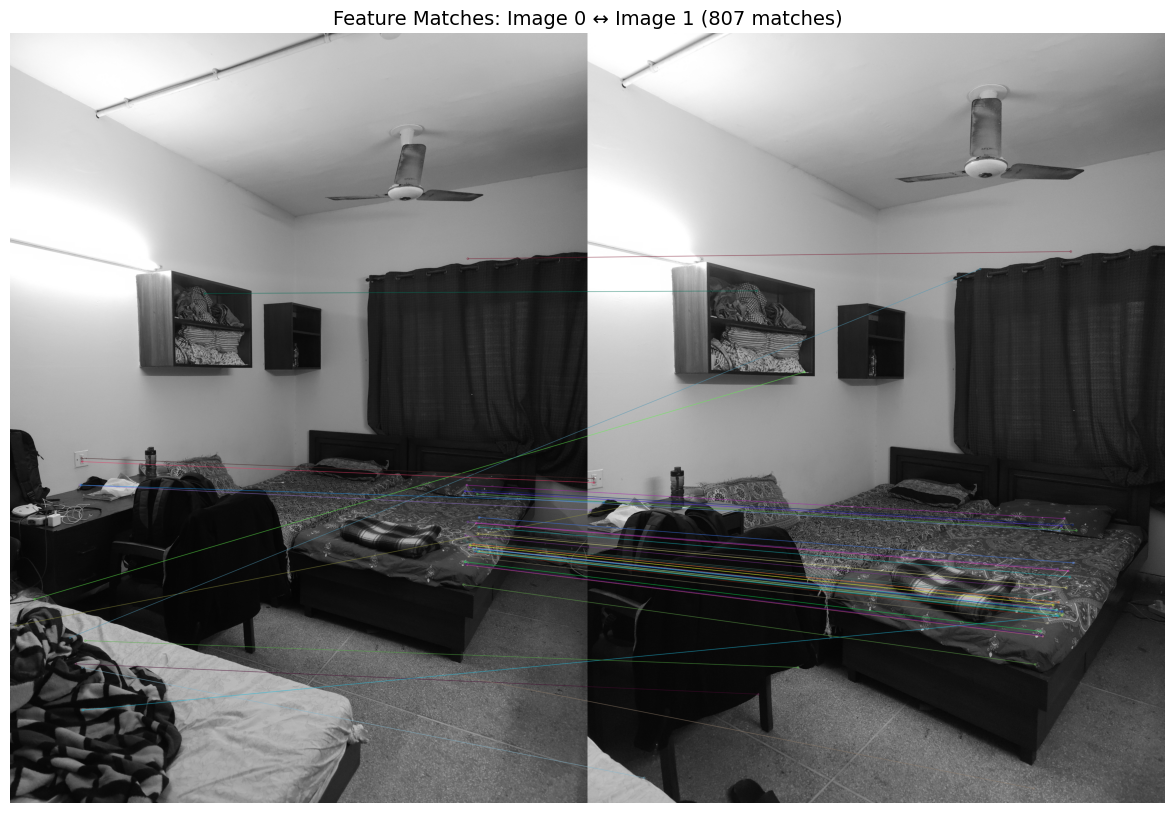


--- Matching Image 1 and Image 2 ---
Found 593 good matches


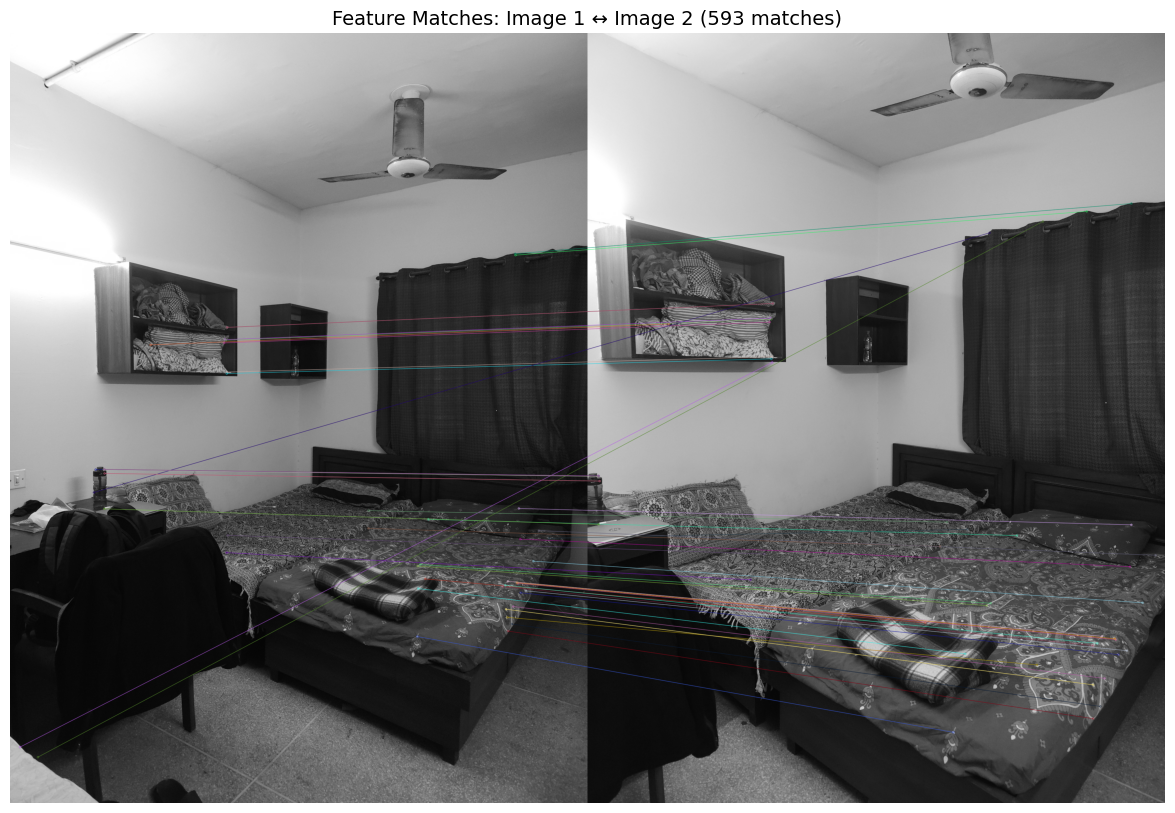


--- Matching Image 2 and Image 3 ---
Found 462 good matches


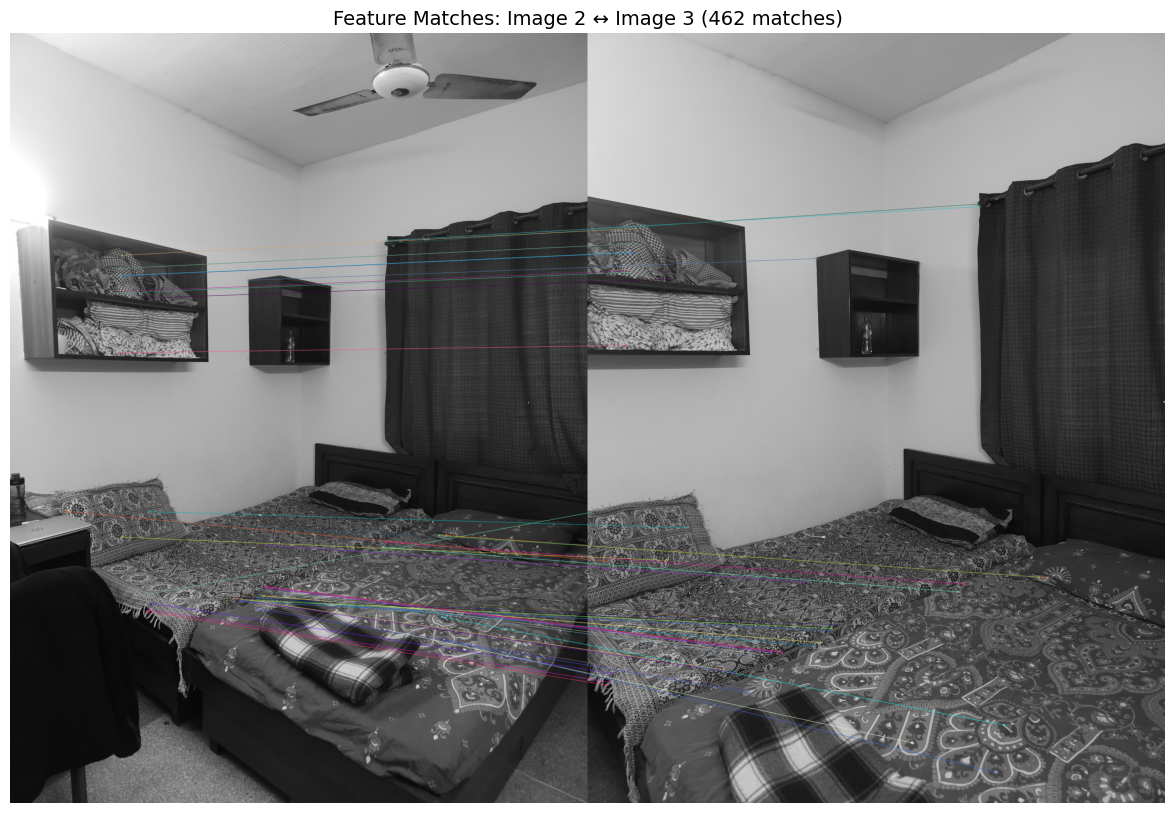


--- Matching Image 3 and Image 4 ---
Found 481 good matches


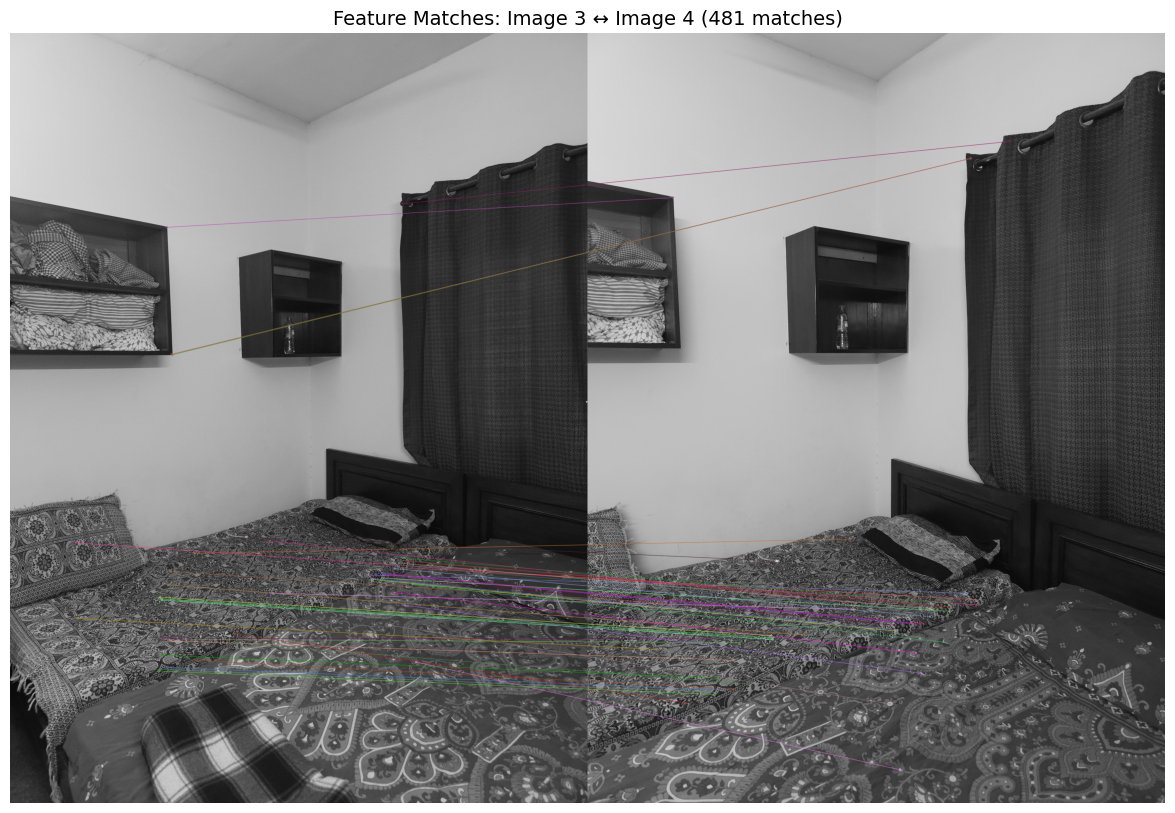


--- Matching Image 4 and Image 5 ---
Found 561 good matches


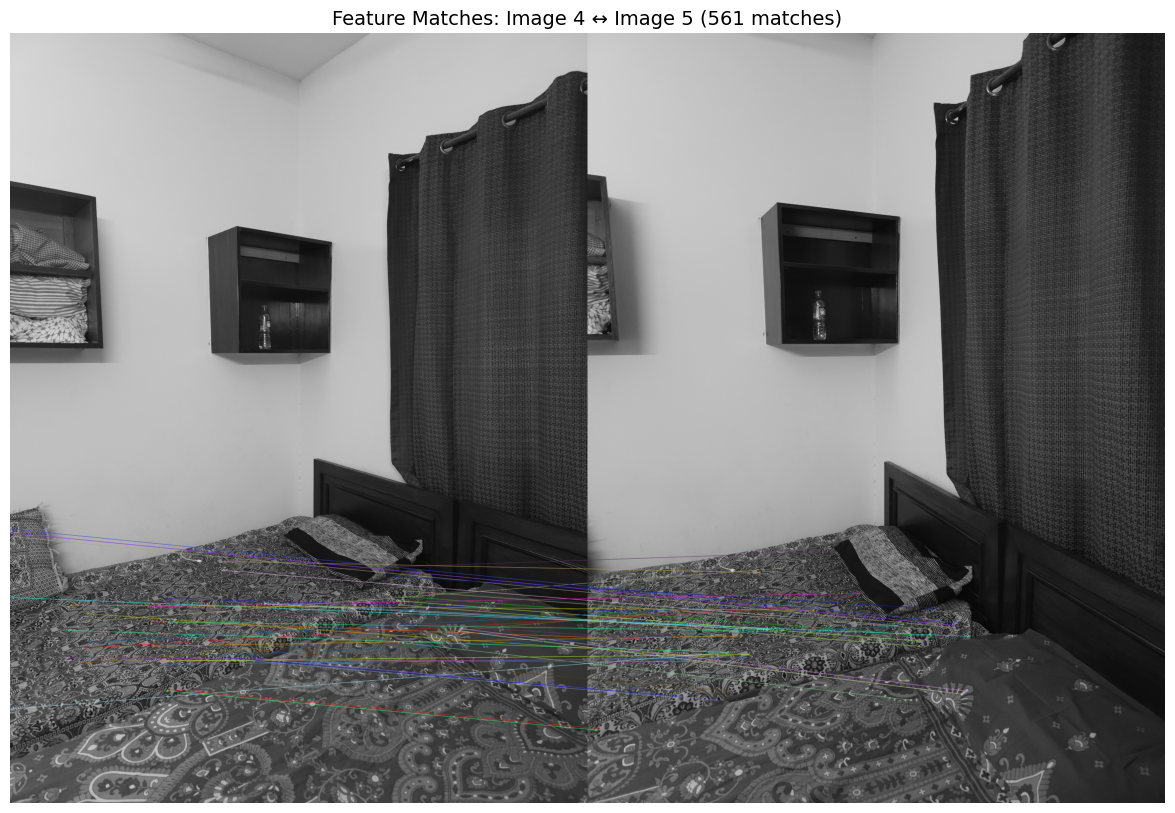

In [31]:

n_pairs = min(5, len(preprocessed_images) - 1)

print(f"Matching features between {n_pairs} consecutive image pairs\n")

for i in range(n_pairs):
    print(f"\n--- Matching Image {i} and Image {i+1} ---")
    
    
    matches = match_features(descriptors_list[i], descriptors_list[i+1])
    
    print(f"Found {len(matches)} good matches")
    
    
    title = f'Feature Matches: Image {i} ↔ Image {i+1} ({len(matches)} matches)'
    visualize_matches(
        preprocessed_images[i], keypoints_list[i],
        preprocessed_images[i+1], keypoints_list[i+1],
        matches, title
    )
    
    

    plt.show()

---

# Week 2: Two-View Reconstruction

Now we'll use the first two images to perform 3D reconstruction.

In [32]:
# Select the first two images for reconstruction
print("\n" + "="*60)
print("WEEK 2: TWO-VIEW RECONSTRUCTION")
print("="*60)

img1_gray = preprocessed_images[0]
img2_gray = preprocessed_images[1]
img1_color = images_color[0]
img2_color = images_color[1]

kp1 = keypoints_list[0]
kp2 = keypoints_list[1]
desc1 = descriptors_list[0]
desc2 = descriptors_list[1]

print(f"\nUsing Image 0 and Image 1 for reconstruction")
print(f"Image 1: {len(kp1)} keypoints")
print(f"Image 2: {len(kp2)} keypoints")

# Match features between the two images
matches = match_features(desc1, desc2, ratio_thresh=0.75)
print(f"Found {len(matches)} matches")


WEEK 2: TWO-VIEW RECONSTRUCTION

Using Image 0 and Image 1 for reconstruction
Image 1: 5000 keypoints
Image 2: 5000 keypoints
Found 913 matches


## 1. Camera Intrinsic Matrix Estimation

Since we don't have calibration data, estimate K from image dimensions.

In [33]:
def estimate_camera_intrinsics(img_shape):
    """
    Estimate camera intrinsic matrix from image dimensions
    Assumes typical FOV and centered principal point
    """
    h, w = img_shape[:2]
    
    # Focal length estimation (assuming ~50-60 degree horizontal FOV)
    focal_length = max(w, h) * 1.2
    
    # Principal point at image center
    cx = w / 2.0
    cy = h / 2.0
    
    # Camera intrinsic matrix
    K = np.array([
        [focal_length, 0, cx],
        [0, focal_length, cy],
        [0, 0, 1]
    ], dtype=np.float64)
    
    return K

K = estimate_camera_intrinsics(img1_gray.shape)
print("\n=== Camera Intrinsic Matrix K ===")
print(K)
print(f"\nFocal length: {K[0,0]:.2f}")
print(f"Principal point: ({K[0,2]:.2f}, {K[1,2]:.2f})")


=== Camera Intrinsic Matrix K ===
[[3.072e+03 0.000e+00 9.600e+02]
 [0.000e+00 3.072e+03 1.280e+03]
 [0.000e+00 0.000e+00 1.000e+00]]

Focal length: 3072.00
Principal point: (960.00, 1280.00)


## 2. Essential Matrix Estimation

Compute Essential matrix using RANSAC to filter outliers.


=== Essential Matrix Estimation ===
Using 913 matched points

Essential Matrix E:
[[-0.00356847 -0.67860701 -0.02875259]
 [ 0.68343076 -0.00218197 -0.1801569 ]
 [ 0.02265122  0.19645415  0.0026281 ]]

Inliers after RANSAC: 434 / 913
Inlier ratio: 47.54%


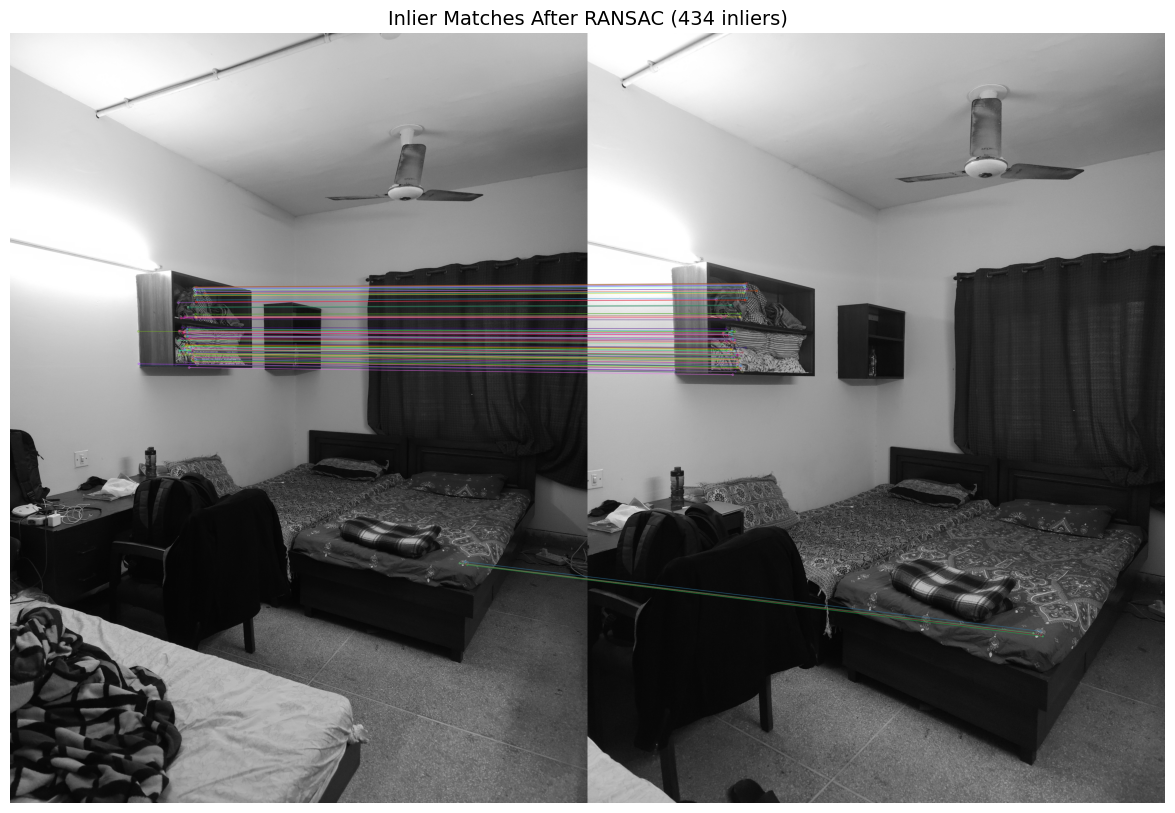

In [34]:
# Extract matched point coordinates
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

print("\n=== Essential Matrix Estimation ===")
print(f"Using {len(pts1)} matched points")

# Estimate Essential matrix using RANSAC
E, mask_e = cv2.findEssentialMat(
    pts1, pts2, K, 
    method=cv2.RANSAC, 
    prob=0.999, 
    threshold=1.0
)

# Filter inliers
inliers = mask_e.ravel() == 1
pts1_inliers = pts1[inliers]
pts2_inliers = pts2[inliers]
matches_inliers = [matches[i] for i in range(len(matches)) if inliers[i]]

print(f"\nEssential Matrix E:")
print(E)
print(f"\nInliers after RANSAC: {np.sum(inliers)} / {len(pts1)}")
print(f"Inlier ratio: {np.sum(inliers)/len(pts1)*100:.2f}%")

# Visualize inlier matches
img_inliers = cv2.drawMatches(
    img1_gray, kp1, img2_gray, kp2, matches_inliers[:100], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(20, 10))
plt.imshow(img_inliers, cmap='gray')
plt.title(f'Inlier Matches After RANSAC ({len(matches_inliers)} inliers)', fontsize=14)
plt.axis('off')
plt.show()

## 3. Camera Pose Recovery

Recover rotation R and translation t from Essential matrix.

In [35]:
print("\n=== Camera Pose Recovery ===")

# Recover pose from Essential matrix
num_inliers, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

print(f"\nRotation Matrix R:")
print(R)
print(f"\nTranslation Vector t:")
print(t.ravel())
print(f"\nNumber of points in front of both cameras: {num_inliers}")

# Verify rotation matrix properties
det_R = np.linalg.det(R)
print(f"\nDeterminant of R (should be ~1): {det_R:.6f}")
print(f"R is orthogonal: {np.allclose(R @ R.T, np.eye(3))}")


=== Camera Pose Recovery ===

Rotation Matrix R:
[[ 0.99968922 -0.00627909  0.02412545]
 [ 0.00602156  0.99992428  0.01073237]
 [-0.02419101 -0.01058376  0.99965133]]

Translation Vector t:
[-0.27803986  0.03036886 -0.96008935]

Number of points in front of both cameras: 434

Determinant of R (should be ~1): 1.000000
R is orthogonal: True


## 4. 3D Point Triangulation

Triangulate 3D points from two camera views.

In [36]:
print("\n=== 3D Point Triangulation ===")

# Create projection matrices
# Camera 1 at origin (identity rotation, zero translation)
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])

# Camera 2 with recovered pose
P2 = K @ np.hstack([R, t])

print("Projection Matrix P1 (Camera 1):")
print(P1)
print("\nProjection Matrix P2 (Camera 2):")
print(P2)

# Triangulate points
print(f"\nTriangulating {len(pts1_inliers)} points...")
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_inliers.T, pts2_inliers.T)

# Convert from homogeneous to 3D coordinates
points_3d = points_4d_hom[:3] / points_4d_hom[3]
points_3d = points_3d.T  # Shape: (N, 3)

print(f"Generated {len(points_3d)} 3D points")
print(f"\n3D points statistics:")
print(f"X range: [{points_3d[:, 0].min():.2f}, {points_3d[:, 0].max():.2f}]")
print(f"Y range: [{points_3d[:, 1].min():.2f}, {points_3d[:, 1].max():.2f}]")
print(f"Z range: [{points_3d[:, 2].min():.2f}, {points_3d[:, 2].max():.2f}]")


=== 3D Point Triangulation ===
Projection Matrix P1 (Camera 1):
[[3.072e+03 0.000e+00 9.600e+02 0.000e+00]
 [0.000e+00 3.072e+03 1.280e+03 0.000e+00]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00]]

Projection Matrix P2 (Camera 2):
[[ 3.04782191e+03 -2.94497647e+01  1.03377866e+03 -1.77582423e+03]
 [-1.24662707e+01  3.05822016e+03  1.31252354e+03 -1.13562123e+03]
 [-2.41910146e-02 -1.05837630e-02  9.99651329e-01 -9.60089354e-01]]

Triangulating 434 points...
Generated 434 3D points

3D points statistics:
X range: [-1.19, 0.73]
Y range: [-1.07, 0.67]
Z range: [4.02, 11.93]


## 5. Filter Valid 3D Points

Remove outliers based on depth and reprojection error.

In [37]:
def filter_points(points_3d, pts1, pts2, R, t, K, max_reproj_error=5.0, max_depth=100.0):
    """Filter 3D points based on validity checks"""
    valid_mask = np.ones(len(points_3d), dtype=bool)
    
    # Check depth in first camera (should be positive Z)
    depths1 = points_3d[:, 2]
    valid_mask &= depths1 > 0
    
    # Check depth in second camera
    points_cam2 = (R @ points_3d.T + t).T
    depths2 = points_cam2[:, 2]
    valid_mask &= depths2 > 0
    
    # Check reasonable depth range
    valid_mask &= depths1 < max_depth
    valid_mask &= depths2 < max_depth
    
    # Check reprojection error for camera 1
    points_2d_proj = (K @ points_3d.T).T
    points_2d_proj = points_2d_proj[:, :2] / points_2d_proj[:, 2:3]
    reproj_error1 = np.linalg.norm(points_2d_proj - pts1, axis=1)
    valid_mask &= reproj_error1 < max_reproj_error
    
    # Check reprojection error for camera 2
    points_2d_proj2 = (K @ points_cam2.T).T
    points_2d_proj2 = points_2d_proj2[:, :2] / points_2d_proj2[:, 2:3]
    reproj_error2 = np.linalg.norm(points_2d_proj2 - pts2, axis=1)
    valid_mask &= reproj_error2 < max_reproj_error
    
    return valid_mask

print("\n=== Filtering 3D Points ===")
valid_mask = filter_points(points_3d, pts1_inliers, pts2_inliers, R, t, K)
points_3d_filtered = points_3d[valid_mask]

print(f"Valid points after filtering: {len(points_3d_filtered)} / {len(points_3d)}")
print(f"Filtered ratio: {len(points_3d_filtered)/len(points_3d)*100:.2f}%")

print(f"\nFiltered 3D points statistics:")
print(f"X range: [{points_3d_filtered[:, 0].min():.2f}, {points_3d_filtered[:, 0].max():.2f}]")
print(f"Y range: [{points_3d_filtered[:, 1].min():.2f}, {points_3d_filtered[:, 1].max():.2f}]")
print(f"Z range: [{points_3d_filtered[:, 2].min():.2f}, {points_3d_filtered[:, 2].max():.2f}]")


=== Filtering 3D Points ===
Valid points after filtering: 434 / 434
Filtered ratio: 100.00%

Filtered 3D points statistics:
X range: [-1.19, 0.73]
Y range: [-1.07, 0.67]
Z range: [4.02, 11.93]


## 6. Extract Point Colors

Get RGB colors for each 3D point from the original image.

In [38]:
# Get colors from the first image
colors = []
for i, is_valid in enumerate(valid_mask):
    if is_valid:
        x, y = pts1_inliers[i].astype(int)
        # Clamp coordinates to image bounds
        y = np.clip(y, 0, img1_color.shape[0] - 1)
        x = np.clip(x, 0, img1_color.shape[1] - 1)
        color = img1_color[y, x]
        colors.append(color)

colors = np.array(colors)
print(f"\nExtracted colors for {len(colors)} points")


Extracted colors for 434 points


## 7. Visualize 3D Point Cloud

Display the reconstructed point cloud with camera positions.

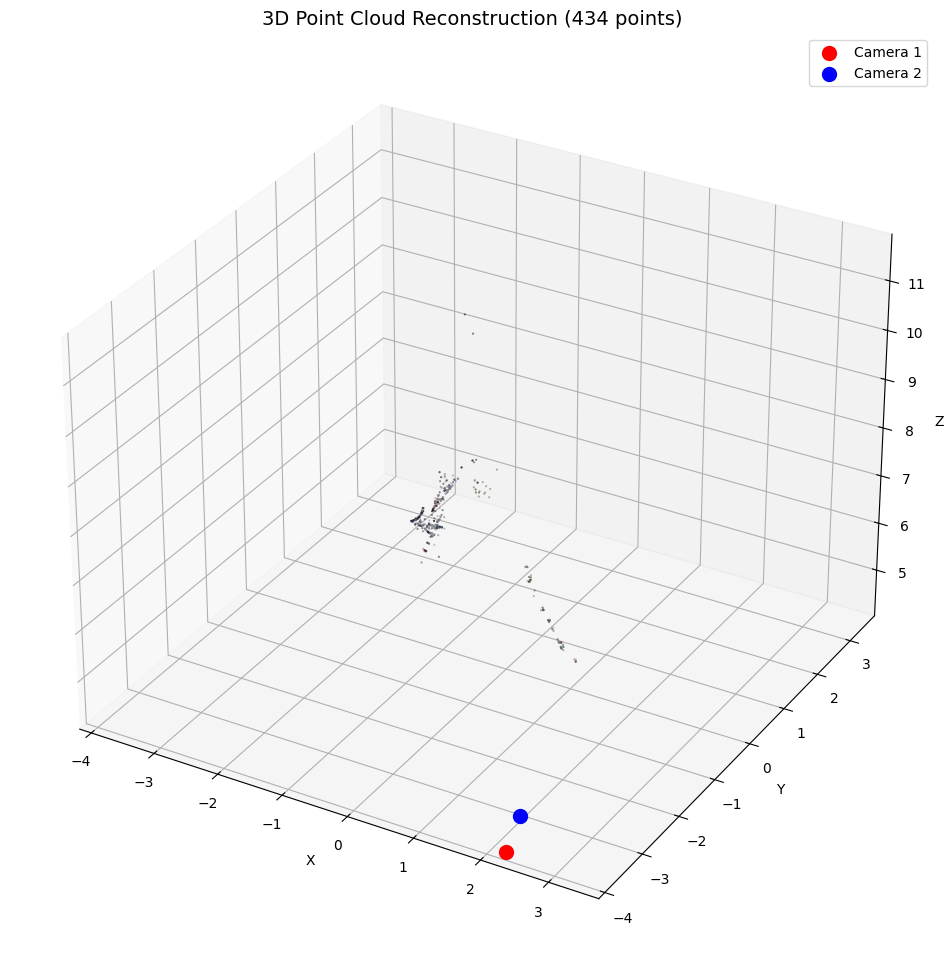

In [39]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D points with colors
ax.scatter(
    points_3d_filtered[:, 0], 
    points_3d_filtered[:, 1], 
    points_3d_filtered[:, 2],
    c=colors/255.0,  # Normalize colors to [0, 1]
    marker='.',
    s=1,
    alpha=0.6
)

# Plot camera positions
ax.scatter([0], [0], [0], c='red', marker='o', s=100, label='Camera 1')
cam2_pos = -R.T @ t
ax.scatter([cam2_pos[0]], [cam2_pos[1]], [cam2_pos[2]], 
           c='blue', marker='o', s=100, label='Camera 2')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Point Cloud Reconstruction ({len(points_3d_filtered)} points)', fontsize=14)
ax.legend()

# Set equal aspect ratio
max_range = np.array([
    points_3d_filtered[:, 0].max() - points_3d_filtered[:, 0].min(),
    points_3d_filtered[:, 1].max() - points_3d_filtered[:, 1].min(),
    points_3d_filtered[:, 2].max() - points_3d_filtered[:, 2].min()
]).max() / 2.0

mid_x = (points_3d_filtered[:, 0].max() + points_3d_filtered[:, 0].min()) * 0.5
mid_y = (points_3d_filtered[:, 1].max() + points_3d_filtered[:, 1].min()) * 0.5
mid_z = (points_3d_filtered[:, 2].max() + points_3d_filtered[:, 2].min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

## 8. Save Point Cloud as PLY File

Export the final 3D point cloud to PLY format.

In [40]:
def save_ply(filename, points, colors):
    """Save point cloud with colors to PLY format"""
    with open(filename, 'w') as f:
        # Write PLY header
        f.write('ply\n')
        f.write('format ascii 1.0\n')
        f.write(f'element vertex {len(points)}\n')
        f.write('property float x\n')
        f.write('property float y\n')
        f.write('property float z\n')
        f.write('property uchar red\n')
        f.write('property uchar green\n')
        f.write('property uchar blue\n')
        f.write('end_header\n')
        
        # Write vertex data
        for point, color in zip(points, colors):
            f.write(f'{point[0]:.6f} {point[1]:.6f} {point[2]:.6f} ')
            f.write(f'{int(color[0])} {int(color[1])} {int(color[2])}\n')
    
    print(f"Point cloud saved to '{filename}'")

# Save the point cloud
output_filename = 'reconstruction.ply'
save_ply(output_filename, points_3d_filtered, colors)

print(f"\n{'='*60}")
print(f"✓ Week 2 Assignment Complete!")
print(f"{'='*60}")
print(f"\nOutput file: {output_filename}")
print(f"Total 3D points: {len(points_3d_filtered)}")
print(f"\nYou can view the PLY file using:")
print("  - MeshLab (http://www.meshlab.net/)")
print("  - CloudCompare (https://www.cloudcompare.org/)")
print("  - Online viewer: https://3dviewer.net/")

Point cloud saved to 'reconstruction.ply'

✓ Week 2 Assignment Complete!

Output file: reconstruction.ply
Total 3D points: 434

You can view the PLY file using:
  - MeshLab (http://www.meshlab.net/)
  - CloudCompare (https://www.cloudcompare.org/)
  - Online viewer: https://3dviewer.net/


In [42]:
# Install: pip install open3d

import open3d as o3d

# Load and visualize PLY file
pcd = o3d.io.read_point_cloud("reconstruction.ply")
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
